This notebook replicates the success model. We plan to add additional features on matchup data

In [134]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss
import xgboost as xgb

In [ ]:
coverage_preds = pd.read_csv("predictions/full_cb_wr_data_preds.csv")
coverage_preds.head()

,gameId,playId,week,nflIdDef,defPlayerName,defenseTeam,defPos,nflIdOff,offPlayerName,possessionTeam,...,epa,defenseWin,offenseWin,heightDef,nflId,height,displayName,heightOff,heightAdv,pred_man
0,2018090600,75,1,2555383,Jalen Mills,PHI,CB,2495454,Julio Jones,ATL,...,0.261827,False,True,74,2495454,74,Julio Jones,74,0,0.037823
1,2018090600,146,1,2552689,Ronald Darby,PHI,CB,2557034,Marvin Hall,ATL,...,-0.372360,True,False,74,2557034,74,Marvin Hall,74,0,0.045660
2,2018090600,146,1,2555383,Jalen Mills,PHI,CB,2560854,Calvin Ridley,ATL,...,-0.372360,True,False,74,2560854,74,Calvin Ridley,74,0,0.058134
3,2018090600,146,1,2557958,Sidney Jones,PHI,CB,2552418,Justin Hardy,ATL,...,-0.372360,True,False,74,2552418,74,Justin Hardy,74,0,0.056922
4,2018090600,168,1,2552689,Ronald Darby,PHI,CB,2533040,Mohamed Sanu,ATL,...,-0.702779,True,False,74,2533040,74,Mohamed Sanu,74,0,0.053701


In [110]:
coverage_preds.drop(columns=["heightAdv"],inplace=True)


In [111]:
for col in coverage_preds.columns:
    if coverage_preds[col].isna().any():
        mode_val = coverage_preds[col].mode().iloc[0]
        coverage_preds[col] = coverage_preds[col].fillna(mode_val)

In [112]:
print(len(coverage_preds))
coverage_preds.head()

45329


,gameId,playId,week,nflIdDef,defPlayerName,defenseTeam,defPos,nflIdOff,offPlayerName,possessionTeam,...,isTarget,epa,defenseWin,offenseWin,heightDef,nflId,height,displayName,heightOff,pred_man
0,2018090600,75,1,2555383,Jalen Mills,PHI,CB,2495454,Julio Jones,ATL,...,True,0.261827,False,True,74,2495454,74,Julio Jones,74,0.037823
1,2018090600,146,1,2552689,Ronald Darby,PHI,CB,2557034,Marvin Hall,ATL,...,False,-0.372360,True,False,74,2557034,74,Marvin Hall,74,0.045660
2,2018090600,146,1,2555383,Jalen Mills,PHI,CB,2560854,Calvin Ridley,ATL,...,True,-0.372360,True,False,74,2560854,74,Calvin Ridley,74,0.058134
3,2018090600,146,1,2557958,Sidney Jones,PHI,CB,2552418,Justin Hardy,ATL,...,False,-0.372360,True,False,74,2552418,74,Justin Hardy,74,0.056922
4,2018090600,168,1,2552689,Ronald Darby,PHI,CB,2533040,Mohamed Sanu,ATL,...,False,-0.702779,True,False,74,2533040,74,Mohamed Sanu,74,0.053701


In [114]:
threshold = 0.6
cols_range = coverage_preds.loc[:, "nFrames":"route"].columns.tolist()

base_feature_block = cols_range 

print("Base feature block:", base_feature_block)

Base feature block: ['nFrames', 'xVar', 'yVar', 'sVar', 'sMax', 'dxVar', 'dyVar', 'xLOS', 'maxDepth', 'endDepth', 'sidelineDistMean', 'sidelineDistVar', 'oppDistMean', 'oppDistVar', 'oppDistMax', 'mateDistMean', 'mateDistVar', 'mateDistMax', 'dirDiffMean', 'dirDiffVar', 'diffOppMean', 'diffOppVar', 'diffQBMean', 'diffQBVar', 'lookingAtQBMean', 'lookingAtQBVar', 'ratMean', 'ratVar', 'route']


In [115]:
target_route_data = (
    coverage_preds
    .loc[(coverage_preds["isTarget"] == True) & (coverage_preds["pred_man"] > threshold)]
    .copy()
)

In [116]:
target_route_data["offenseWin"] = (target_route_data["offenseWin"] == True).astype(int)

In [117]:
keep_cols = ["offenseWin"] + base_feature_block
keep_cols = [c for c in keep_cols if c in target_route_data.columns]
target_route_data = target_route_data[keep_cols].copy()
target_route_data.head()


,offenseWin,nFrames,xVar,yVar,sVar,sMax,dxVar,dyVar,xLOS,maxDepth,...,dirDiffVar,diffOppMean,diffOppVar,diffQBMean,diffQBVar,lookingAtQBMean,lookingAtQBVar,ratMean,ratVar,route
33,1,46,14.248030,0.227893,4.828194,5.85,0.046278,0.004749,53,11.47,...,0.173455,1.097409,0.128095,0.485784,0.046317,0.978261,0.021739,0.658593,0.319591,HITCH
36,0,37,2.328919,1.645368,3.472226,4.64,0.015790,0.018585,63,4.74,...,0.728048,1.041232,0.101858,0.160934,0.005093,1.000000,0.000000,0.190135,0.006535,IN
44,1,46,6.874092,0.687001,4.023692,6.32,0.023160,0.041033,93,6.08,...,2.786602,1.611995,0.536358,2.487468,0.630940,0.239130,0.185990,0.153015,0.002860,GO
66,1,54,22.959642,3.905063,5.108370,6.55,0.056859,0.006151,34,11.68,...,0.241266,1.064156,0.350889,1.677381,0.967121,0.296296,0.212439,0.152395,0.005335,GO
86,0,34,0.110150,1.099553,3.207770,6.15,0.008319,0.029288,41,3.90,...,6.001543,1.369956,0.084085,0.277080,0.027637,1.000000,0.000000,0.767044,0.004983,IN


In [118]:
len(target_route_data)


2397

In [119]:
from sklearn.preprocessing import LabelEncoder

# Encoder for route
le_route = LabelEncoder()
target_route_data["route"] = le_route.fit_transform(
    target_route_data["route"].astype(str)
)

# Check mappings
#print("Formation mapping:", dict(zip(le_formation.classes_, le_formation.transform(le_formation.classes_))))
print("Route mapping:", dict(zip(le_route.classes_, le_route.transform(le_route.classes_))))


Route mapping: {'CORNER': 0, 'CROSS': 1, 'FLAT': 2, 'GO': 3, 'HITCH': 4, 'IN': 5, 'OUT': 6, 'POST': 7, 'SCREEN': 8, 'SLANT': 9, 'undefined': 10}


In [120]:
target_route_data.head()

,offenseWin,nFrames,xVar,yVar,sVar,sMax,dxVar,dyVar,xLOS,maxDepth,...,dirDiffVar,diffOppMean,diffOppVar,diffQBMean,diffQBVar,lookingAtQBMean,lookingAtQBVar,ratMean,ratVar,route
33,1,46,14.248030,0.227893,4.828194,5.85,0.046278,0.004749,53,11.47,...,0.173455,1.097409,0.128095,0.485784,0.046317,0.978261,0.021739,0.658593,0.319591,4
36,0,37,2.328919,1.645368,3.472226,4.64,0.015790,0.018585,63,4.74,...,0.728048,1.041232,0.101858,0.160934,0.005093,1.000000,0.000000,0.190135,0.006535,5
44,1,46,6.874092,0.687001,4.023692,6.32,0.023160,0.041033,93,6.08,...,2.786602,1.611995,0.536358,2.487468,0.630940,0.239130,0.185990,0.153015,0.002860,3
66,1,54,22.959642,3.905063,5.108370,6.55,0.056859,0.006151,34,11.68,...,0.241266,1.064156,0.350889,1.677381,0.967121,0.296296,0.212439,0.152395,0.005335,3
86,0,34,0.110150,1.099553,3.207770,6.15,0.008319,0.029288,41,3.90,...,6.001543,1.369956,0.084085,0.277080,0.027637,1.000000,0.000000,0.767044,0.004983,5


In [121]:
X = target_route_data.drop(columns=["offenseWin"])
y = target_route_data["offenseWin"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1072021, stratify=y)

In [122]:
len(y_train)

1917

In [123]:
dtrain = xgb.DMatrix(X_train.values, label=y_train.values , feature_names=list(X_train.columns))
dtest  = xgb.DMatrix(X_test.values,  label=y_test.values, feature_names=list(X_test.columns))
watchlist = [(dtrain, "train"), (dtest, "val")]

In [124]:
rng = np.random.default_rng(1072021)
param_grid = pd.DataFrame({
    "max_depth": rng.integers(3, 11, size=100),
    "eta":       rng.uniform(0.01, 0.3, size=100),
    "subsample": rng.uniform(0.7, 1.0, size=100),
    "colsample_bytree": rng.uniform(0.6, 1.0, size=100)
})

val_scores = []
best_models = []
for i, row in param_grid.iterrows():
    params = {
        "booster": "gbtree",
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "max_depth": int(row["max_depth"]),
        "eta": float(row["eta"]),
        "subsample": float(row["subsample"]),
        "colsample_bytree": float(row["colsample_bytree"]),
        # Fast tree builder
        "tree_method": "hist",
    }
    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=100,
        evals=watchlist,
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    # For logloss, lower is better; store negative logloss as "val_acc"-like higher-is-better if you want,
    # but we'll keep the true best_score (logloss) and sort ascending later.
    val_scores.append(bst.best_score)
    best_models.append(bst)

In [125]:

param_grid["val_logloss"] = val_scores
param_grid = param_grid.sort_values("val_logloss", ascending=True).reset_index(drop=True)

print("\n=== Random Search (logloss) ===")
print("Best validation logloss:", param_grid.loc[0, "val_logloss"])


=== Random Search (logloss) ===
Best validation logloss: 0.6736293569207191


In [126]:
best = param_grid.iloc[0].to_dict()
best

{'max_depth': 3.0,
 'eta': 0.2558541321325786,
 'subsample': 0.924623322671051,
 'colsample_bytree': 0.9908922506444402,
 'val_logloss': 0.6736293569207191}

In [127]:
params_tuned = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": int(best["max_depth"]),
    "eta": float(best["eta"]),
    "subsample": float(best["subsample"]),
    "colsample_bytree": float(best["colsample_bytree"]),
    "tree_method": "hist",
}

xgb_tune = xgb.train(
    params=params_tuned,
    dtrain=dtrain,
    num_boost_round=100,
    evals=watchlist,
    early_stopping_rounds=10,
    verbose_eval=False,
)

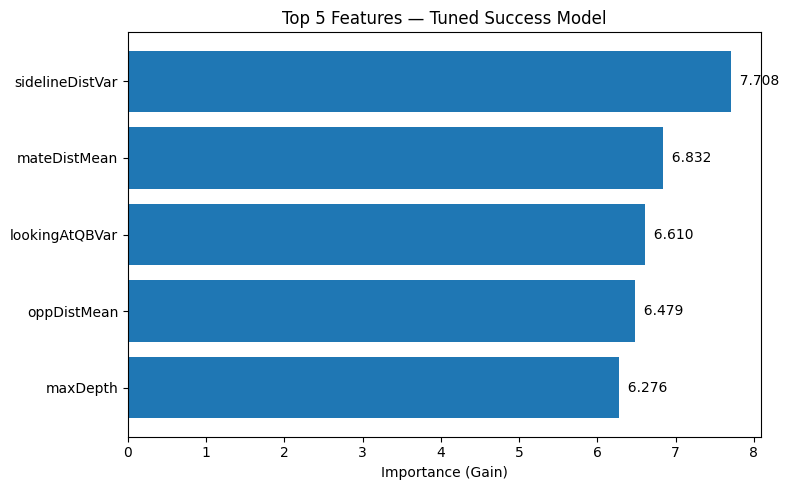

In [128]:
# Ensure your DMatrix kept real column names when training:
# dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns)
# dtest  = xgb.DMatrix(X_test,  label=y_test,  feature_names=X_test.columns)
# ...then train xgb_tune as you did.

import pandas as pd
import matplotlib.pyplot as plt

# 1) Grab importances with real names
imp = xgb_tune.get_score(importance_type="gain")  # or "weight", "cover"
imp_df = pd.DataFrame(list(imp.items()), columns=["feature", "importance"])

# Safety: if empty (rare), bail early
if imp_df.empty:
    print("No feature importances found. Check that feature_names were set on DMatrix.")
else:
    # 2) Top 5
    top5 = imp_df.sort_values("importance", ascending=False).head(5)

    # 3) Pretty horizontal bar chart (matplotlib only)
    plt.figure(figsize=(8, 5))
    y = top5["feature"][::-1]        # reverse for top at top
    x = top5["importance"][::-1]
    plt.barh(y, x)
    plt.xlabel("Importance (Gain)")
    plt.title("Top 5 Features — Tuned Success Model")
    # Add value labels
    for i, v in enumerate(x):
        plt.text(v, i, f"  {v:.3f}", va="center")
    plt.tight_layout()
    plt.show()


In [129]:
pred_test_prob = xgb_tune.predict(dtest)
pred_test = (pred_test_prob > 0.5).astype(int)

print("\n=== Tuned XGBoost: Test Metrics ===")
print("LogLoss:", log_loss(y_test, pred_test_prob))
print("Accuracy:", accuracy_score(y_test, pred_test))
print(confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test, digits=4))


=== Tuned XGBoost: Test Metrics ===
LogLoss: 0.6829091287841462
Accuracy: 0.58125
[[198  69]
 [132  81]]
              precision    recall  f1-score   support

           0     0.6000    0.7416    0.6633       267
           1     0.5400    0.3803    0.4463       213

    accuracy                         0.5813       480
   macro avg     0.5700    0.5609    0.5548       480
weighted avg     0.5734    0.5813    0.5670       480



In [130]:
import seaborn as sns

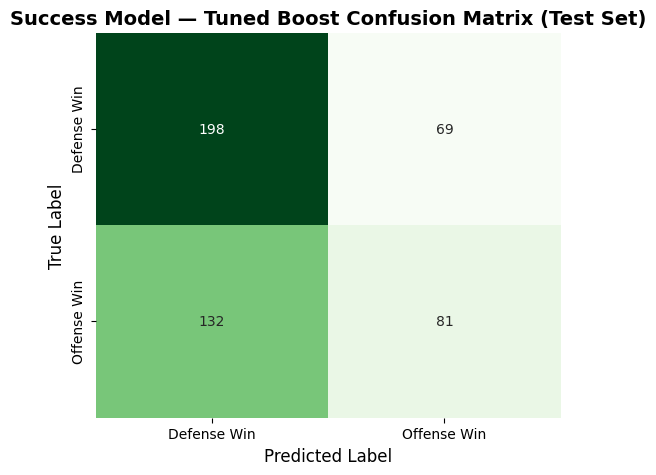

In [131]:
y_pred_prob_succ = xgb_tune.predict(dtest)
y_pred_succ = (y_pred_prob_succ > 0.5).astype(int)

# Confusion matrix
cm_succ = confusion_matrix(y_test, y_pred_succ)

# Labels: 0 = Defense win, 1 = Offense win
labels = ["Defense Win", "Offense Win"]

# Pretty green heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm_succ, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels, cbar=False)

plt.title("Success Model — Tuned Boost Confusion Matrix (Test Set)", fontsize=14, weight="bold")
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()

In [132]:
full_coverage_data = (
    coverage_preds
    .loc[coverage_preds["pred_man"] > threshold]
    .copy()
)

In [133]:
len(full_coverage_data) # we are predicting on all man to man plays not the other ones

12212

In [33]:
full_keep_cols = [c for c in base_feature_block if c in full_coverage_data.columns]
X_full_raw = full_coverage_data[full_keep_cols].copy()

In [34]:
X_full_raw.head()
X_full_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14217 entries, 15 to 45323
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nFrames              14217 non-null  int64  
 1   xVar                 14217 non-null  float64
 2   yVar                 14217 non-null  float64
 3   sVar                 14217 non-null  float64
 4   sMax                 14217 non-null  float64
 5   dxVar                14217 non-null  float64
 6   dyVar                14217 non-null  float64
 7   xLOS                 14217 non-null  int64  
 8   maxDepth             14217 non-null  float64
 9   endDepth             14217 non-null  float64
 10  sidelineDistMean     14217 non-null  float64
 11  sidelineDistVar      14217 non-null  float64
 12  oppDistMean          14217 non-null  float64
 13  oppDistVar           14217 non-null  float64
 14  oppDistMax           14217 non-null  float64
 15  mateDistMean         14217 non-null  flo

In [35]:
for df in [X_full_raw]:
    if "route" in df.columns:
        df["route"] = df["route"].replace("WHEEL", "undefined")

In [36]:
X_full_raw["route"] = le_route.transform(
    X_full_raw["route"].astype(str)
)

In [37]:
X_full_raw["offenseFormation"] = le_formation.transform(
    X_full_raw["offenseFormation"].astype(str)
)


In [38]:
dfull = xgb.DMatrix(X_full_raw.values, feature_names=list(X_full_raw.columns))

In [39]:
pred_full_prob = xgb_tune.predict(dfull)

In [40]:
len(pred_full_prob) 

14217

# I have all the probs I need

In [41]:
final_matchup_data = (
    coverage_preds
    .loc[coverage_preds["pred_man"] > threshold]
    .copy()
)

In [42]:
final_matchup_data.head()

,gameId,playId,week,nflIdDef,defPlayerName,defenseTeam,defPos,nflIdOff,offPlayerName,possessionTeam,...,heightOff,pred_man,quarter,down,yardsToGo,yardline_100,offenseFormation,defendersInTheBox,numberOfPassRushers,poss_score_diff
15,2018090600,521,1,2555383,Jalen Mills,PHI,CB,2495454,Julio Jones,ATL,...,74,0.927545,1,1,10,90,SINGLEBACK,8.0,3.0,0.0
16,2018090600,545,1,2552689,Ronald Darby,PHI,CB,2495454,Julio Jones,ATL,...,74,0.833723,1,2,7,93,SINGLEBACK,7.0,4.0,0.0
17,2018090600,545,1,2555383,Jalen Mills,PHI,CB,2560854,Calvin Ridley,ATL,...,74,0.673507,1,2,7,93,SINGLEBACK,7.0,4.0,0.0
18,2018090600,545,1,2557958,Sidney Jones,PHI,CB,2533040,Mohamed Sanu,ATL,...,74,0.965428,1,2,7,93,SINGLEBACK,7.0,4.0,0.0
31,2018090600,992,1,2539334,Desmond Trufant,ATL,CB,2507763,Mike Wallace,PHI,...,74,0.529701,2,1,10,40,SINGLEBACK,7.0,4.0,-3.0


In [43]:

final_matchup_data["pred_offenseWin"] = pred_full_prob

In [44]:
final_matchup_data.head()

,gameId,playId,week,nflIdDef,defPlayerName,defenseTeam,defPos,nflIdOff,offPlayerName,possessionTeam,...,pred_man,quarter,down,yardsToGo,yardline_100,offenseFormation,defendersInTheBox,numberOfPassRushers,poss_score_diff,pred_offenseWin
15,2018090600,521,1,2555383,Jalen Mills,PHI,CB,2495454,Julio Jones,ATL,...,0.927545,1,1,10,90,SINGLEBACK,8.0,3.0,0.0,0.452887
16,2018090600,545,1,2552689,Ronald Darby,PHI,CB,2495454,Julio Jones,ATL,...,0.833723,1,2,7,93,SINGLEBACK,7.0,4.0,0.0,0.493041
17,2018090600,545,1,2555383,Jalen Mills,PHI,CB,2560854,Calvin Ridley,ATL,...,0.673507,1,2,7,93,SINGLEBACK,7.0,4.0,0.0,0.546332
18,2018090600,545,1,2557958,Sidney Jones,PHI,CB,2533040,Mohamed Sanu,ATL,...,0.965428,1,2,7,93,SINGLEBACK,7.0,4.0,0.0,0.346427
31,2018090600,992,1,2539334,Desmond Trufant,ATL,CB,2507763,Mike Wallace,PHI,...,0.529701,2,1,10,40,SINGLEBACK,7.0,4.0,-3.0,0.492801


In [45]:
len(final_matchup_data)

14217

In [46]:
final_matchup_data.to_csv("predictions/final_matchup_data_v2.csv", index=False)
print("\nSaved final_matchup_data.csv")



Saved final_matchup_data.csv


evaluate whether you get ball or not 


what are the chances you get targeted given the route 



next step:

feature engineer multiple flavors of it 
each one tackles some part of football


expected separation metric (linear regression or GAM)

where you move relative to the closest defender




mixed modelling opportunity 


P(catch | target) * P(target) = P(catch and targeted)

move --> stats 